# 18.S097/16.S092 Problem Set 2 Solutions

## Problem 1 (5+5+5 points)

**(a)** Implement the power method for the $5 \times 5$ matrix $A=A^T$ with entries given below (in Julia format, but you can easily paste the rows into Python if you want), starting with a random $x$.  (Don't forget to normalize $x$ on each step.)  Plot the first component `x[1]` of the vector (`x[0]` in Python) as a function of the iteration $k$, for 50 iterations.    You should find that it is *not* converging, even if you do thousands of iterations.  Explain why, by analyzing $A$.

**(b)** For the same power iteration, also plot the estimated eigenvalue from the Rayleigh quotient $R(x) = x^T A x / x^T x$.   Show experimentally that this ratio *is* converging with iteration, but that it converges to a *different* value depending on the starting $x$.   Explain this theoretically.  (Hint: imagine expanding your initial vector in terms of the eigenvectors of $A$, and write $R(x)$ as we did in class.  What happens as the iterations increase?  Your analysis of $A$ from part (a) is relevant here.)

**(c)** Take the **last two iterations** $x_{49}, x_{50}$ of your power iteration from part (a).   Given these two vectors, construct an orthonormal basis for their span and implement the Rayleigh–Ritz procedure from class.  Show that the Ritz values accurately give you the biggest two $|\lambda|$ of $A$ and that the Ritz vectors are corresponding eigenvectors.

In [6]:
A = [1.4476317999449781 -0.6465393230357954   0.2033943818754874    -0.6010878430154134  0.23307116396384292
    -0.6465393230357954  0.245131330148544   -0.010910634569569148  -0.22452148400766606 1.102670053450075
     0.2033943818754874 -0.010910634569569148 0.5527569734349188     1.2392098548325268 -0.00039661249386200957
    -0.6010878430154134 -0.22452148400766606  1.2392098548325268    -0.2892571481659739  0.8941545793109221
     0.23307116396384292 1.102670053450075   -0.00039661249386200957 0.8941545793109221  0.043737044637532294]

5×5 Matrix{Float64}:
  1.44763   -0.646539    0.203394     -0.601088   0.233071
 -0.646539   0.245131   -0.0109106    -0.224521   1.10267
  0.203394  -0.0109106   0.552757      1.23921   -0.000396612
 -0.601088  -0.224521    1.23921      -0.289257   0.894155
  0.233071   1.10267    -0.000396612   0.894155   0.043737

### Solutions:

**(a)**

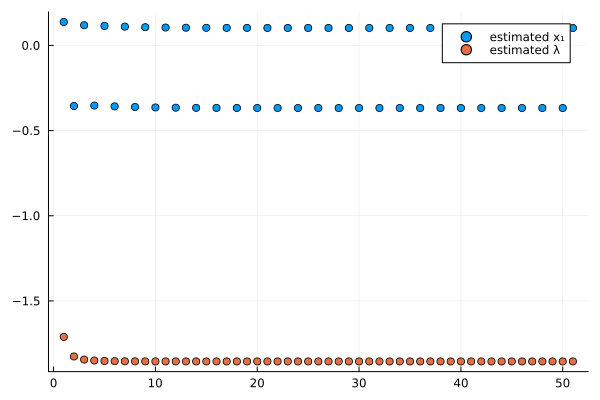

In [23]:
using LinearAlgebra

x = randn(5)
est_λ = [x'*A*x / x'x]
x1 = [x[1]]
for k = 1:50
    x = normalize!(A*x)
    push!(est_λ, x'*A*x / x'x)
    push!(x1, x[1])
end

using Plots
scatter(x1, label="estimated x₁")
scatter!(est_λ, label="estimated λ")

In [7]:
eigvals(A)

5-element Vector{Float64}:
 -1.999999999999999
 -0.500000000000001
  0.9999999999999997
  1.4999999999999996
  2.0000000000000004

**(b)**

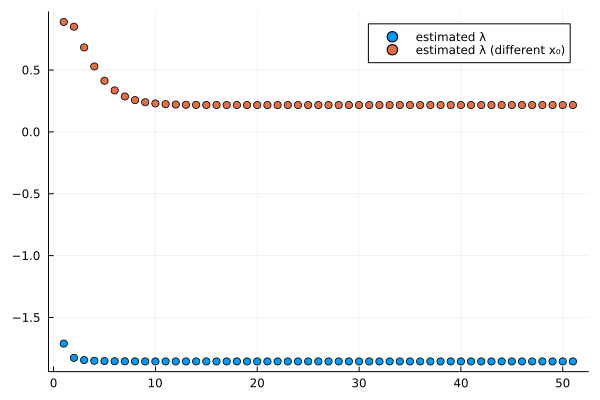

In [24]:
x = randn(5)
est_λ2 = [x'*A*x / x'x]
for k = 1:50
    x = normalize!(A*x)
    push!(est_λ2, x'*A*x / x'x)
end

using Plots
scatter(est_λ, label="estimated λ")
scatter!(est_λ2, label="estimated λ (different x₀)")

**(c)**

In [30]:
x = randn(5)
est_λ = [x'*A*x / x'x]
x1 = [x[1]]
for k = 1:49
    x = normalize!(A*x)
end
x49 = x
x50 = normalize!(A*x)

Q = Matrix(qr([x49 x50]).Q)
H = Q' * A * Q
F = eigen(H)
F.values

2-element Vector{Float64}:
 -1.999999999999712
  1.9999999999991103

In [31]:
X = Q * F.vectors
norm(A * X - X * Diagonal(F.values)) / norm(A * X)

4.263395770169733e-7

## Problem 2 (5+5 points)

Consider the Rayleigh quotient $R(x) = \frac{x^T A x}{x^T x}$ for a real matrix $A$.

**(a)** Suppose $A = A^T$.  In class, we claimed that *any* eigenvector of $A$ will then be an extremum of $R$.  Show this: explicitly compute $\nabla R$ (exercise your 18.02 skills!) and show that $\nabla R = 0$ if and only if $x$ is an eigenvector.

**(b)** Suppose that $A \ne A^T$.   In this case, eigenvectors of $A$ will *not* generally be extrema of $R$.  Instead, the extrema of $R$ (where $\nabla R = 0$) will be eigenvectors of *some other* matrix.  What matrix?  (Revisit your calculation from (a): what changes if $A$ is not symmetric?)

## Problem 3 (5+5+5 points)

This problem is based problem 8.3.5 from the [*FNC* book section 8.3](https://fncbook.com/inviter).  This exercise concerns the $n^2\times n^2$ sparse matrix defined by `A = FNC.poisson(n)` for integer $n$ — see the provided [Julia implementation](https://github.com/fncbook/FNCFunctions.jl/blob/236e736cd052081d67c487c8835dcabb0221437a/src/chapter08.jl#L153-L166) or the [Python implementation `poisson2d(n)`](https://github.com/fncbook/fnc/blob/0149be86ebf930b6455c3b8500f8dc818afadda7/python/pkg/FNC/FNC08.py#L135-L141). It represents a discretized ($n \times n$ grid) model of a vibrating square membrane held fixed around the edges.

**(a)** Implement inverse iteration (the power method with $A^{-1}$) with zero shift).  Do *not* explicitly compute $A^{-1}$.  Instead, compute a sparse LU factorization *once* (or better yet sparse Cholesky, since this matrix is symmetric positive-definite) using an appropriate library function, and re-use it for each power iteration.  Using sufficiently many iterations your code, **find the eigenvalue** $\lambda$ closest to zero for $n=10,15,20,25$ to many digits of accuracy.

The eigenvalues can be interpreted as the squares of the vibration frequencies.  It turns out that the lowest vibration frequency is $\sqrt{2}$ for an exact wave equation in the $n \to \infty$ limit, so the lowest eigenvalue should be converging to $2$ as $n$ increases.  `poisson` uses a second-order center-difference approximation, so the error should be $O(1/n^2)$ — **verify that your λ data** is consistent with this prediction.

**(b)** For each $n$ in part (a), apply 50 steps of inverse iteration. On one graph, **plot the convergence of fractional error** $|\Delta \lambda| / |\lambda|$ in the estimated eigenvalue  **as a function of iteration** for each of the four $n$'s.  (Use the value from (a) as the "exact" value … if you ran (a) for much more than 50 iterations it should be accurate enough.)  Why should this converge at similar rates for different $n$ values?

**(c)** Let `v` be the eigenvector found by your inverse iteration for $n=25$. **Make a plot of the vibration mode** by reshaping `v` into an $n\times n$ matrix (use something like a heatmap, contour, or 3d surface plot).   For $n \to \infty$, it turns out that this eigenvector should converge to the function $\sin(x) \sin(y)$ on a $[0,\pi] \times [0, \pi]$ domain — **plot this analytical solution side-by-side** with your computed eigenvector.

## Solutions:

**(a)**

In [34]:
using SparseArrays, LinearAlgebra

function poisson(n)
    D =
        spdiagm(
            -1 => fill(-1, n-1),
            0 => fill(2, n),
            1 => fill(-1, n-1)) * (n+1)^2 / π^2
    return Hermitian(kron(D, I(n)) + kron(I(n), D))
end

poisson (generic function with 1 method)

In [37]:
function inviter(A, N, x₀=randn(float(eltype(A)), size(A,1)))
    λ_history = eltype(x₀)[]
    F = cholesky(A)
    x = x₀
    for k = 1:N
        x = normalize!(F \ x)
        push!(λ_history, x'*A*x / (x'x))
    end
    return λ_history[end], x, λ_history
end

inviter (generic function with 2 methods)

In [42]:
ns = [10,15,20,25]
λ = [inviter(poisson(n), 500)[1] for n in ns]

4-element Vector{Float64}:
 1.9864424118578978
 1.993582728089921
 1.9962727722601115
 1.9975678494961704

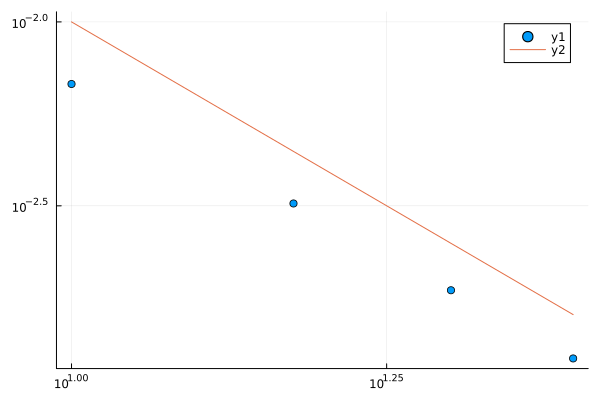

In [46]:
relerr(val, exact) = abs(val - exact) / abs(exact)
scatter(ns, relerr.(λ,2), xaxis=:log10, yaxis=:log10)
plot!(ns, 1 ./ ns.^2)

**(b)**

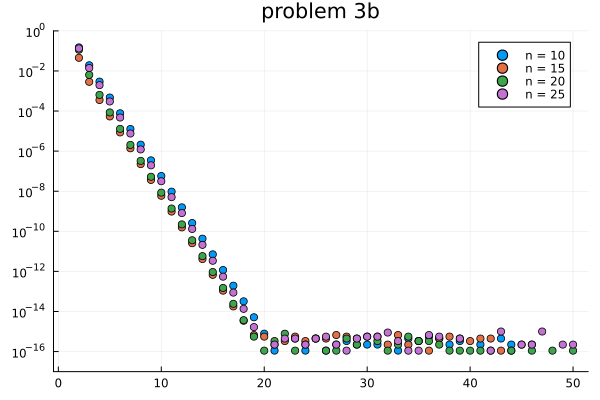

In [60]:
λhist = [inviter(poisson(n), 50)[3] for n in ns]

plot(title="problem 3b", yaxis=:log10, ylim=(1e-17, 1), yticks=exp10.(-16:2:0))
for i = 1:length(ns)
    λerr = relerr.(λhist[i], λ[i])
    scatter!(λerr, label="n = $(ns[i])")
end
plot!()

**(c)**

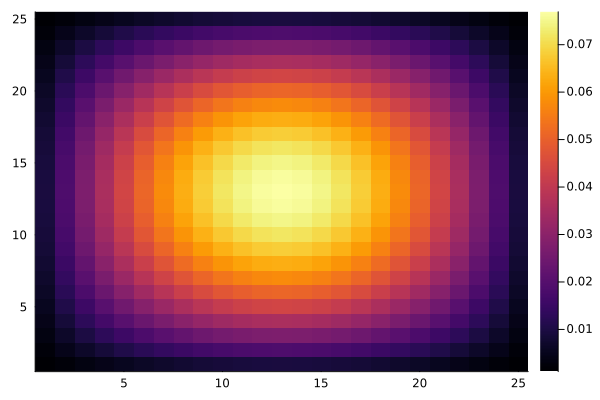

In [62]:
n = 25
v = reshape(inviter(poisson(n), 50)[2], n, n)
heatmap(v)